# Section 9 - Web Scraping and Web Crawling
Data from websites are not always neatly organized. We call this **unstructured data**. Most webpages are rendered in **HTML**, a programming language designed for layout and formatting. But in order to understand how to work with unstructured data from websites we need to know a little bit of HTML. CodeAcademy has a great free [HTML tutorial](https://www.codecademy.com/learn/learn-html), which covers even more than what we need for this section. We are also going to use a little bit of **regular expressions** (or RegEx), which is a special string describing a search pattern. And here is a great [RegEx tutorial](https://regexone.com/).

Now that we know the basics of HTML, you should also learn how to **open the source code panel** of your web browser. If you are using Google Chrome, just press F12. If you are using Safari on a Mac, you need to **enable the developer menu**:
1. Click on *Safari Menu* > *Preferences* > *Advanced*
1. Check the *"show Develop menu in the menu bar"*
1. Now there a is a drop down menu called *Develop*, with the *view source* option.

In this notebook we are going to use some new libraries:
* **`requests`**: Allows to grab the source code and other characteristics of a webpage.
* **`BeaultifulSoup4`**: Interprets text as sorce code and lets you grab the parts you want.
* **`re`**: The RegEx module that is already built in python.

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import re
import pandas as pd
from tqdm import tqdm

For now, our target is going to the **G1 website**.

https://g1.globo.com/

We can use the requests library to `get` the contents of the page.

In [3]:
response = requests.get('http://g1.globo.com')
type(response)

SSLError: HTTPSConnectionPool(host='g1.globo.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])")))

notice that the `get` method returns a specific object of the `requests` library. Let's take a look at the atributes of the object.

In [ ]:
dir(response)

Try a few of these attributes on the next cell. The most important for us is going to be `.text` method.

In [ ]:
response.text

We can use RegEx to search content in this page. For example, let's **grab all the URLs from G1 website**.

In [ ]:
regex_html_url = '''href=["'](.[^"']+)["']'''  # RegEx for URLs
re.findall(regex_html_url, response.text)

Notice that you can now write a program to visit all the avaible URLs from G1 home page and turn your webscrapper into a webcrawler.

Now, let's say we want to **grab the text from all the headlines**.

In [ ]:
response = requests.get('http://g1.globo.com')
headlines = bs(response.content, 'html.parser').find_all('a', class_='feed-post-link gui-color-primary gui-color-hover')

print(len(headlines))

headlines

To grab the contents inside a HTML tag, use the `.get_text` method

In [ ]:
print(type(headlines[0]), '\n')

print(headlines[0])

headlines[0].get_text()

In [ ]:
for i in range(len(headlines)):
    print(headlines[i].get_text(), '\n')

---
# Scraping Emails

[Students from the masters of economics in PUC-Rio](http://www.econ.puc-rio.br/pessoas/alunos-mestrado)

In [ ]:
response = requests.get('http://www.econ.puc-rio.br/pessoas/alunos-mestrado')

regExpEmail = '[\w\.-]+@[\w\.-]+' # RegEx for email
re.findall(regExpEmail, response.text)

If you click on the name of a student, you can see that the URL ends with something that looks like an ID number. The link for the first one is 

http://www.econ.puc-rio.br/pessoas/perfil/1

If you keep adding 1 to this ID number, you will go through everybody that is registered in the department of economics from PUC-Rio.

Not all the ID numbers are valid. For example, number 17 returns an error

http://www.econ.puc-rio.br/pessoas/perfil/17

In [ ]:
requests.get('http://www.econ.puc-rio.br/pessoas/perfil/17').text

We are going to use this in our favor. Whenever the string "fatal error" is in the response we are going to skip that ID number.

In [ ]:
re.findall('Fatal error', requests.get('http://www.econ.puc-rio.br/pessoas/perfil/17').text)

In case the page exists, we use `beatifulsoup` to grab the HTML tag of the person's name and a regular expression search to get the email. We are searching for different information using different methods for a reason. The person's name is always under the `<h5>` HTML tag, while several other information are under the same tag `<a>`.

In [ ]:
response = requests.get('http://www.econ.puc-rio.br/pessoas/perfil/18')

soup = bs(response.content.decode('utf-8','ignore'), 'html.parser')

In [ ]:
all_a = soup.find_all('a')
for p in all_a:
    print(p.get_text())

Here is a single example

In [ ]:
print(soup.find_all('h5')[0].get_text())

print(re.findall(regExpEmail , response.text)[0])

Now, all we have to do is iterate on the ID of the URL and save the name and email, but we have to handle two types of errors:
* We skip the iteration if the page is not avilable. To handle this we check if the string "fatal error" is on the page.
* If there is no email on the page, we have to save a blank. To handle this problem we use the `try-except` clause.

In [ ]:
# Creates empty lists that are going to store the data
Nomes = []
Emails = []

# loops for IDs from 1 to 2000
for i in tqdm(range(1, 3000)):    
    
    #if i%250 == 0:
     #   print('buscando pagina', i)
    
    response = requests.get('http://www.econ.puc-rio.br/pessoas/perfil/' + str(i))
    
    if 'Fatal error' in re.findall('Fatal error', response.text):
        continue  # skips to the next iteration
    else:
        nome_i = bs(response.content.decode('utf-8','ignore'), 'html.parser').find_all('h5')[0].text
        
        try:
            email_i = re.findall(regExpEmail, response.text)[0]
        except IndexError:
            email_i = ''
  
        Nomes.append(nome_i)
        Emails.append(email_i)
        
EmailsPUC = pd.DataFrame(data={'Nomes':Nomes, 'Emails':Emails}).sort_values('Nomes')

In [ ]:
EmailsPUC

In [ ]:
EmailsPUC[EmailsPUC['Nomes'].str.contains('Gustavo')].dropna().sort_values('Nomes')

One way to protect yourself from webscraping is to not write your email **explicitly**. Here is an example from Marcos Lopez de Prado [website](http://www.quantresearch.info/).


---
## Query Strings: URLs with Parameters
Everything after "?" is the query string and it is meant to contain data that does not fit within a URL’s normal hierarchical path structure

https://www.google.com.br/search?q=pesquisa+eleitoral+bolsonaro&num=3&as_sitesearch=g1.com.br

* query string comes at the end of a URL, starting with a single question mark, “?”.
* Parameters are provided as key-value pairs and separated by an ampersand, “&”.
* The key and value are separated using an equals sign, “=”.

'<!doctype html><html lang="pt-BR"><head><meta charset="UTF-8"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>pesquisa eleitoral bolsonaro site:g1.com.br - Pesquisa Google</title><script nonce="5kTWgameHMLriGzn53XnzQ==">(function(){var a=window.performance;window.start=(new Date).getTime();a:{var b=window;if(a){var c=a.timing;if(c){var d=c.navigationStart,e=c.responseStart;if(e>d&&e<=window.start){window.start=e;b.wsrt=e-d;break a}}a.now&&(b.wsrt=Math.floor(a.now()))}}window.google=window.google||{};google.aft=function(f){f.setAttribute("data-iml",+new Date)};}).call(this);(function(){var c=[],e=0;window.ping=function(b){-1==b.indexOf("&zx")&&(b+="&zx="+(new Date).getTime());var a=new Image,d=e++;c[d]=a;a.onerror=a.onload=a.onabort=function(){delete c[d]};a.src=b};}).call(this);</script><style>body{margin:0 auto;max-width:736px;padding:0 8px}a{color:#1967D2;text-decoration:none;tap-highlight-color:rgba(0,0,0,.1)}a:visited{color:#4B1
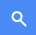

In [3]:
url = 'https://www.google.com.br/search?q=pesquisa+eleitoral+bolsonaro&num=3&as_sitesearch=g1.com.br'
res = requests.get(url)
res.text

We want an easy way to change the parameters of our search. Luckily, the `requests` library already has a functionality for URL queries.

In [4]:
url = 'https://www.google.com.br/search'

param_dict = {'q': 'programa+de+governo', 
              'num': '3', 
              'as_sitesearch': 'g1.com.br'}

response = requests.get(url, params=param_dict)

response.url

'https://www.google.com.br/search?q=programa%2Bde%2Bgoverno&num=3&as_sitesearch=g1.com.br'

## Practical Example - Derivatives Settlement Prices from B3
An applied example of this is going to be relevant for is scraping sttlement prices from the B3 derivatives.

http://www2.bmf.com.br/pages/portal/bmfbovespa/lumis/lum-sistema-pregao-enUS.asp?Data=10/01/2018&Mercadoria=DOL

In [ ]:
url = 'http://www2.bmf.com.br/pages/portal/bmfbovespa/lumis/lum-sistema-pregao-enUS.asp'
param_dict = {'Data': '10/01/2018', 'Mercadoria': 'DOL'}
r = requests.get(url, params=param_dict)
r.text

---
# Webdrivers
First we need to install the [**selenium webdriver library**](https://www.seleniumhq.org/projects/webdriver/). This library allows you to command the web browsers. We will use **Google Chrome** as our web browser, so we need the [**Chrome Driver**](https://sites.google.com/a/chromium.org/chromedriver/downloads)

In [6]:
from selenium import webdriver
import datetime as dt
import time as time
import os

ModuleNotFoundError: No module named 'selenium'

In [5]:
driver_options = webdriver.ChromeOptions()

browser = webdriver.Chrome(r'\\bw2k1201app\groupbrw$\BWGI\Thiago Barros\Drivers\chromedriver', 
                           chrome_options=driver_options)

browser.get(r'https://www3.bcb.gov.br/expectativas/publico/consulta/serieestatisticas')

NameError: name 'webdriver' is not defined

select the indicator

In [ ]:
xpath = r'//*[@id="indicador"]/option[5]'
browser.find_element_by_xpath(xpath).click()

Select the price index

In [ ]:
xpath = r'//*[@id="grupoIndicePreco:opcoes_5"]'
browser.find_element_by_xpath(xpath).click()

select the metric

In [ ]:
xpath = r'//*[@id="calculo"]/option[3]'
browser.find_element_by_xpath(xpath).click()

Select the periodicity

In [ ]:
xpath = r'//*[@id="periodicidade"]/option[3]'
browser.find_element_by_xpath(xpath).click()

Fill the dates

In [ ]:
initial_date = dt.date(2018, 1, 10)
xpath = r'//*[@id="tfDataInicial1"]'
browser.find_element_by_xpath(xpath).send_keys(initial_date.strftime('%d/%m/%Y'))

end_date = dt.date(2018, 11, 16)
xpath = r'//*[@id="tfDataFinal2"]'
browser.find_element_by_xpath(xpath).send_keys(end_date.strftime('%d/%m/%Y'))

Fill initial year and final year

In [ ]:
xpath = r'//*[@id="form4"]/div[2]/table/tbody[3]/tr/td[2]/select/option[2]'
browser.find_element_by_xpath(xpath).click()

# trick - always grabs the last element
xpath = r'//*[@id="form4"]/div[2]/table/tbody[3]/tr/td[4]/select'
selection = browser.find_element_by_xpath(xpath)
selection.click()
options = selection.find_elements_by_tag_name('option')
options[len(options) - 1].click()

click the download button

In [ ]:
xpath = r'//*[@id="btnXLSa"]'
browser.find_element_by_xpath(xpath).click()

download_save_time = dt.datetime.now()  # saves the time the file was downloaded

Get the default download directory

Probably only works on windows

In [ ]:
username = os.getlogin()
download_path = r'C:\Users\%(user)s\Downloads' % {'user': username}
download_path

Explain the walk method
dirpath
dirname
filename

In [ ]:
list(os.walk(download_path))

Look for the files in the download path

In [ ]:
for (dirpath, dirnames, filenames) in os.walk(download_path):
    
    for f in filenames:
    
        if 'Séries de estatísticas' in f:
            file_save_time = os.path.getmtime(dirpath + '\\' + f)
            file_save_time = dt.datetime.fromtimestamp(file_save_time)
            
            if file_save_time > save_time:
                file_path = dirpath + '\\' + f
                
print(file_path)

read the file and clean the dataframe

In [ ]:
df = pd.read_excel(file_path, skiprows=1, na_values=[' '])

df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.set_index('Data')
df

In [ ]:
import matplotlib.pyplot as plt
df.plot(figsize=(15, 8))
plt.show()

All together now

In [ ]:
driver_options = webdriver.ChromeOptions()

browser = webdriver.Chrome(r'\\bw2k1201app\groupbrw$\BWGI\Thiago Barros\Drivers\chromedriver', 
                           chrome_options=driver_options)

browser.get(r'https://www3.bcb.gov.br/expectativas/publico/consulta/serieestatisticas')

xpath = r'//*[@id="indicador"]/option[5]'
browser.find_element_by_xpath(xpath).click()

xpath = r'//*[@id="grupoIndicePreco:opcoes_5"]'
browser.find_element_by_xpath(xpath).click()

xpath = r'//*[@id="calculo"]/option[3]'
browser.find_element_by_xpath(xpath).click()

xpath = r'//*[@id="periodicidade"]/option[3]'
browser.find_element_by_xpath(xpath).click()

initial_date = dt.date(2018, 1, 10)
xpath = r'//*[@id="tfDataInicial1"]'
browser.find_element_by_xpath(xpath).send_keys(initial_date.strftime('%d/%m/%Y'))

end_date = dt.date(2018, 11, 16)
xpath = r'//*[@id="tfDataFinal2"]'
browser.find_element_by_xpath(xpath).send_keys(end_date.strftime('%d/%m/%Y'))

xpath = r'//*[@id="form4"]/div[2]/table/tbody[3]/tr/td[2]/select/option[2]'
browser.find_element_by_xpath(xpath).click()

# trick - always grabs the last element
xpath = r'//*[@id="form4"]/div[2]/table/tbody[3]/tr/td[4]/select'
selection = browser.find_element_by_xpath(xpath)
selection.click()
options = selection.find_elements_by_tag_name('option')
options[len(options) - 1].click()

xpath = r'//*[@id="btnXLSa"]'
browser.find_element_by_xpath(xpath).click()

download_save_time = dt.datetime.now()  # saves the time the file was downloaded

time.sleep(6)  # give some time for the download to finish

browser.close()

username = os.getlogin()
download_path = r'C:\Users\%(user)s\Downloads' % {'user': username}

for (dirpath, dirnames, filenames) in os.walk(download_path):
    
    for f in filenames:
    
        if 'Séries de estatísticas' in f:
            file_save_time = os.path.getmtime(dirpath + '\\' + f)
            file_save_time = dt.datetime.fromtimestamp(file_save_time)
            
            if file_save_time > save_time:
                file_path = dirpath + '\\' + f
                
df = pd.read_excel(file_path, skiprows=1, na_values=[' '])

df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.set_index('Data')

df.plot(figsize=(15, 8))
plt.show()